# 503 Project Q2

## Prelude：data cleaning

In [1]:
# 0.import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from pygam import LinearGAM, s, f, l
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
import sklearn.metrics
from sklearn import tree
from PIL import Image
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,r2_score, matthews_corrcoef
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor

In [2]:
# 1.Load data

weight = pd.read_csv('503_2024_spring/P_WHQ.csv')
demo = pd.read_csv('503_2024_spring/P_DEMO.csv')
sleep = pd.read_csv('503_2024_spring/P_SLQ.csv')
diet = pd.read_csv('503_2024_spring/P_DBQ.csv')
activity = pd.read_csv('503_2024_spring/P_PAQ.csv')
smoke = pd.read_csv('503_2024_spring/P_SMQ.csv')
alcohol = pd.read_csv('503_2024_spring/P_ALQ.csv')


In [3]:
# 2.filter variables  
# df_all

#(1) weight
weight_var_index = [0,2,5,7,] + [i for i in np.arange(8,22)]+[23,25,26,27]
df_all = weight.iloc[:,weight_var_index]
#(2) demographic : 4 variables
demo_subset = demo.loc[:,['SEQN','RIAGENDR','RIDAGEYR','DMDMARTZ','DMDEDUC2']]
df_all = pd.merge(df_all, demo_subset, how = 'inner', on = 'SEQN')
#(3) sleep : 3 variables
sleep_subset = sleep.loc[:,['SEQN','SLD012','SLD013','SLQ120']]
df_all = pd.merge(df_all, sleep_subset, how = 'inner', on = 'SEQN')
#(4) diet : 2 variables
diet_subset = diet.loc[:,['SEQN','DBD905','DBD910']]
df_all = pd.merge(df_all, diet_subset, how = 'inner', on = 'SEQN')
#(5) activity
# PAQ650 is like vigorous activity, and PAQ665 is like moderate
activity_subset = activity.loc[:,['SEQN',
                              'PAQ635','PAQ640',
                              'PAQ650','PAQ655',
                              'PAQ665','PAQ670','PAD680']]
df_all = pd.merge(df_all, activity_subset, how = 'inner', on = 'SEQN')
#(6) smoke : 4 variables
# Note: this dataset is really special! If 'SMQ020' is no, 
# all following will be missing
# 'SMD641' is not good
smoke_subset = smoke.loc[:,['SEQN','SMQ020','SMQ040',
                            'SMD650']]        

df_all = pd.merge(df_all, smoke_subset, how = 'inner', on = 'SEQN')  
#(7) alcohol
# 'ALQ280,290' just measures a single day; ALQ142 is like intemperance
alcohol_subset = alcohol.loc[:,['SEQN','ALQ111', 'ALQ121','ALQ130','ALQ142',
                               'ALQ170']]
df_all = pd.merge(df_all, alcohol_subset, how = 'inner', on = 'SEQN')

In [4]:
# 3.data processing

# self-define function
def lw_category(name,num):
    df_all[name] = np.where(df_all[name] == num, 1, 0)

#(1) weight
df_all = df_all[df_all.WHD020 <= 578]
df_all = df_all[df_all.WHD050 <= 618]
lw_category('WHD080A',10)
lw_category('WHD080B',11)
lw_category('WHD080C',12)
lw_category('WHD080D',13)
lw_category('WHD080E',14)
lw_category('WHD080F',15)
lw_category('WHD080G',16)
lw_category('WHD080H',17)
lw_category('WHD080I',31)
lw_category('WHD080J',32)
lw_category('WHD080K',33)
lw_category('WHD080M',34)
lw_category('WHD080N',30) # special
lw_category('WHD080O',41)
lw_category('WHD080Q',43)
lw_category('WHD080S',45)
lw_category('WHD080T',46)
lw_category('WHD080U',35)
#(2) demographic
df_all = df_all[df_all.DMDMARTZ <= 3.0]
df_all = df_all[df_all.DMDEDUC2 <= 5.0]
df_all['RIAGENDR'] = np.where(df_all['RIAGENDR'] == 2, 1, 0) # femlae:1, male:0
df_all['DMDMARTZ'] = np.where(df_all['DMDMARTZ'] == 3.0, 0, # single:0, married:1, divorce:2
                              np.where(df_all['DMDMARTZ'] == 1.0, 1, 2))
df_all['DMDEDUC2'] = np.where(df_all['DMDEDUC2'] == 3, 1,
                              np.where(df_all['DMDEDUC2'] == 4, 2,
                              np.where(df_all['DMDEDUC2'] == 5, 3,0))) #lower:0 high school:1, 
                                                                       #college:2, graduatge: 3, 
# (3) sleep
df_all = df_all[df_all.SLQ120 <= 4] 
df_all = df_all[df_all.SLD012 <= 14] # deal with missing values
df_all = df_all[df_all.SLD013 <= 14]
df_all['sleep_overall'] =  np.where((df_all['SLD012'] < 7)&(df_all['SLD013'] < 7), 0,
                                    np.where((df_all['SLD012'] >= 7)&(df_all['SLD013'] >= 7),2,1)) 
                                                                #sleep worst:0, middle：1,#best: 2, 

# (4) diet
df_all = df_all[df_all['DBD905'] <= 100]
df_all = df_all[df_all['DBD910'] < 100]

#(5) activity
df_all = df_all[df_all['PAQ635'] <= 2] # deal missing
df_all.loc[df_all['PAQ635'] == 2.0,'PAQ635'] = 0 # bicycle yes:1, no:0
df_all.loc[df_all['PAQ635'] == 0,'PAQ640'] = 0
df_all = df_all[df_all['PAQ640'] <= 7] # deal missing
df_all.loc[df_all['PAQ650'] == 2,'PAQ650'] = 0
df_all.loc[df_all['PAQ650'] == 0,'PAQ655'] = 0
df_all = df_all[df_all['PAQ655'] <= 7] # deal missing
df_all = df_all[df_all['PAQ665'] <= 2] # deal missing
df_all.loc[df_all['PAQ665'] == 2.0,'PAQ665'] = 0 # moderate activity yes:1, no:0
df_all.loc[df_all['PAQ665'] == 0,'PAQ670'] = 0
df_all = df_all[df_all['PAQ670'] <= 7] # deal missing
df_all = df_all[df_all['PAD680'] <= 1320] # deal missing

# (6) smoke
df_all = df_all[df_all['SMQ020'] <= 2] # deal missing      0:no smoke; 1:some: 2:everyday
df_all['smoke_now'] = np.where(df_all['SMQ020'] == 2.0, 0, 
                             np.where(df_all['SMQ040'] == 3, 0,
                             np.where(df_all['SMQ040'] == 2, 1,2))) 
# df_all = df_all.fillna({'SMD641':0})
# df_all = df_all[df_all.SMD641 <= 30]
df_all = df_all.fillna({'SMD650':0})
df_all = df_all[df_all.SMD650 <= 45]

# (7) alcohol
df_all = df_all[df_all['ALQ111'] <= 2] # deal missing
# a lot of work here, ensure that smaller number implies less drinking
df_all.loc[df_all['ALQ111'] == 2.0,'ALQ121'] = 0.0
df_all = df_all[df_all['ALQ121'] <= 10.0] # deal missing
df_all['ALQ121'] = 11 - df_all['ALQ121']
df_all.loc[df_all['ALQ121'] == 11.0,'ALQ121'] = 0
# ALQ130 cleaning
df_all.loc[(df_all['ALQ111'] == 2.0)|(df_all['ALQ121'] == 0),'ALQ130'] = 0.0
df_all = df_all[df_all['ALQ130'] <= 15.0] # deal missing
# ALQ 142, same process as ALQ121
df_all.loc[(df_all['ALQ111'] == 2.0)|(df_all['ALQ121'] == 0),'ALQ142'] = 0.0
df_all = df_all[df_all['ALQ142'] <= 10.0] # deal missing
df_all['ALQ142'] = 11 - df_all['ALQ142']
df_all.loc[df_all['ALQ142'] == 11.0,'ALQ142'] = 0
# ALQ170 cleaning
df_all.loc[(df_all['ALQ111'] == 2.0)|(df_all['ALQ121'] == 0),'ALQ170'] = 0.0
df_all = df_all[df_all['ALQ170'] <= 30.0] # deal missing

# remove redundant variables
df_all = df_all.drop(['SEQN','SLD012','SLD013',
                     'SMQ020','SMQ040','ALQ111'],axis = 1)

In [5]:
# 4.choose the sample
# sample: want to lose weight
df_wls_b_one_hot = df_all[df_all.WHQ070==1.0]
Y = df_wls_b_one_hot['WHD020'].values - df_wls_b_one_hot['WHD050'].values
df_wls_b_one_hot = df_wls_b_one_hot.drop(['WHD020','WHQ070'],axis = 1)
df_wls_b_one_hot.insert(loc=0,column='weight_change',value=Y)


print(df_wls_b_one_hot.shape)
print('min',min(Y), '\ max',max(Y))
df_wls_b_one_hot.head()

(2558, 41)
min -106 \ max 125


,weight_change,WHD050,WHD080A,WHD080B,WHD080C,WHD080D,WHD080E,WHD080F,WHD080G,WHD080H,...,PAQ665,PAQ670,PAD680,SMD650,ALQ121,ALQ130,ALQ142,ALQ170,sleep_overall,smoke_now
0,10,200,0,1,0,1,0,0,0,0,...,1,4.0,480.0,0.0,1.0,1.0,0.0,0.0,2,0
5,8,170,0,1,0,0,0,0,0,0,...,0,0.0,360.0,0.0,0.0,0.0,0.0,0.0,2,0
7,15,140,1,1,1,1,0,0,0,0,...,1,2.0,180.0,0.0,0.0,0.0,0.0,0.0,0,0
12,5,115,0,0,1,1,1,1,0,0,...,0,0.0,600.0,0.0,5.0,2.0,0.0,0.0,2,0
14,3,127,0,0,1,1,0,0,0,0,...,0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,1,0


#### Additional One-hot encoding

In [6]:
# (2) demographic
df_all['mar_marry'] = np.where(df_all['DMDMARTZ'] == 1, 1, 0)
df_all['mar_divorce'] = np.where(df_all['DMDMARTZ'] == 2, 1, 0)
df_all['edu_high'] = np.where(df_all['DMDEDUC2'] == 1, 1, 0)
df_all['edu_col'] = np.where(df_all['DMDEDUC2'] == 2, 1, 0)
df_all['edu_gra'] = np.where(df_all['DMDEDUC2'] == 3, 1, 0)
#(3) sleep
df_all['day_tired_rare'] = np.where(df_all['SLQ120'] == 1, 1, 0)
df_all['day_tired_some'] = np.where(df_all['SLQ120'] == 2, 1, 0)
df_all['day_tired_often'] = np.where(df_all['SLQ120'] >=3 , 1, 0)
df_all['sleep_best'] = np.where(df_all['sleep_overall'] == 2, 1, 0)
df_all['sleep_soso'] = np.where(df_all['sleep_overall'] == 1, 1, 0)
# (4) diet
# special
df_all.loc[df_all['DBD905']>=10,'DBD905'] = 10
# (6) smoke
df_all['smoke_some'] = np.where(df_all['smoke_now'] == 1, 1,0)
df_all['smoke_often'] = np.where(df_all['smoke_now'] == 2, 1,0)

df_all = df_all.drop(['DMDMARTZ','DMDEDUC2','SLQ120',
                     'sleep_overall','smoke_now'],axis = 1)

df_wls = df_all[df_all.WHQ070==1.0]
Y = df_wls['WHD020'].values - df_wls['WHD050'].values
df_wls = df_wls.drop(['WHD020','WHQ070'],axis = 1)
df_wls.insert(loc=0,column='weight_change',value=Y)
print(df_wls.shape)
print('min',min(Y), '\ max',max(Y))
df_wls.head()


(2558, 48)
min -106 \ max 125


,weight_change,WHD050,WHD080A,WHD080B,WHD080C,WHD080D,WHD080E,WHD080F,WHD080G,WHD080H,...,edu_high,edu_col,edu_gra,day_tired_rare,day_tired_some,day_tired_often,sleep_best,sleep_soso,smoke_some,smoke_often
0,10,200,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,8,170,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,15,140,1,1,1,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
12,5,115,0,0,1,1,1,1,0,0,...,0,1,0,0,0,0,1,0,0,0
14,3,127,0,0,1,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0


## Q2. Weight loss strategy and regression

### Method1:Linear model

#### 1) cross validation

In [7]:
# cross validation
k_cv = 5
cv = KFold(n_splits=k_cv, random_state=2023, shuffle=True)

In [8]:
# x and y
Y_wls = df_wls['weight_change'].values
X_wls = df_wls.drop(['weight_change'],axis=1)

# linear regression
linear_wls = LinearRegression()

# Calculate MSE across folds
scores_linear = -cross_val_score(linear_wls, X_wls, Y_wls, scoring='neg_mean_squared_error', cv=cv)
scores_linear

array([183.76172453, 237.8255746 , 209.40484015, 223.42887122,
       223.1121305 ])

In [9]:
print(f"Mean MSE: {scores_linear.mean():.4f}, plus minus {np.sqrt(scores_linear.var()/len(scores_linear)):.4f}")

Mean MSE: 215.5066, plus minus 8.1577


#### 2) train/test split

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_wls, Y_wls, 
                                                    train_size=0.7, random_state=3)

#### 3）regression and predict

In [11]:
# Linear fit
linear_wls.fit(X_train, Y_train)

y_train_pred = linear_wls.predict(X_train)
y_test_pred = linear_wls.predict(X_test)

print('MSE:',mean_squared_error(Y_test,y_test_pred))
print('R^2 train:',f'\033[1m{r2_score(Y_train,y_train_pred):.3f}\033[0m')
print('R^2 test: ',f'\033[1m{r2_score(Y_test,y_test_pred):.3f}')

MSE: 243.8995145368983
R^2 train: 0.089
R^2 test:  0.015


#### 4）Result

In [12]:
X_train_df = pd.DataFrame(X_train)
X_train_df.columns = df_wls.iloc[:,1:].columns
model_jjj = sm.OLS(Y_train, X_train_df.assign(intercept=1)).fit()
  
# model summary
print(model_jjj.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     3.623
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           5.90e-15
Time:                        14:36:03   Log-Likelihood:                -7247.3
No. Observations:                1790   AIC:                         1.459e+04
Df Residuals:                    1742   BIC:                         1.485e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
WHD050             -0.0255      0.007     

### Method2: Lasso

##### consider normalize

In [13]:
X_scaled_train = preprocessing.StandardScaler().fit_transform(X_train)
X_scaled_test = preprocessing.StandardScaler().fit_transform(X_test)

alpha_range = np.logspace(-2,2,200,base=10)
# LassoCV
lasso_ = LassoCV(alphas=alpha_range, cv=cv).fit(X_scaled_train, Y_train)

# best
best_alpha = lasso_.alpha_ 
print(best_alpha)

lasso_wls_scaled = Lasso(alpha = 0.4055)
lasso_wls_scaled.fit(X_scaled_train, Y_train)

y_train_pred = lasso_wls_scaled.predict(X_scaled_train)
y_test_pred = lasso_wls_scaled.predict(X_scaled_test)

print('MSE:',mean_squared_error(Y_test,y_test_pred))
print('R^2 train:',f'\033[1m{r2_score(Y_train,y_train_pred):.3f}\033[0m')
print('R^2 test: ',f'\033[1m{r2_score(Y_test,y_test_pred):.3f}')

0.3217641750250737
MSE: 238.01576927766897
R^2 train: 0.068
R^2 test:  0.039


In [14]:
# Calculate MSE across folds
scores_lasso = -cross_val_score(lasso_wls_scaled, X_wls, Y_wls, scoring='neg_mean_squared_error', cv=cv)
scores_lasso

array([187.37673649, 239.26909652, 204.89989822, 216.64854023,
       218.50446204])

In [15]:
print(f"Mean MSE: {scores_lasso.mean():.4f}, plus minus {np.sqrt(scores_lasso.var()/len(scores_lasso)):.4f}")

Mean MSE: 213.3397, plus minus 7.6296


#### 3）Result

In [16]:
dic={'特征':X_wls.columns,'系数':lasso_wls_scaled.coef_}
df_jjj = pd.DataFrame(dic)
df_1_jjj = df_jjj[df_jjj['系数']!=0]

X_train_lasso = X_train_df.loc[:,df_1_jjj.iloc[:,0]]
model_jjj = sm.OLS(Y_train, X_train_lasso.assign(intercept=1)).fit()
  
# model summary
print(model_jjj.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     7.344
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           3.17e-21
Time:                        14:36:03   Log-Likelihood:                -7255.9
No. Observations:                1790   AIC:                         1.456e+04
Df Residuals:                    1768   BIC:                         1.468e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
WHD050             -0.0275      0.007     

### Method3: GAM

In [17]:
Y_wls_gam = df_wls_b_one_hot['weight_change'].values
X_wls_gam = df_wls_b_one_hot.drop(['weight_change'],axis=1)
X_train_gam, X_test_gam, Y_train_gam, Y_test_gam = train_test_split(X_wls_gam, Y_wls_gam, 
                                                    train_size=0.7, random_state=3)

# get back the factor!!!
                                 # train
X_gam = X_train_lasso.drop(['edu_high','edu_gra', 'day_tired_often','sleep_best'], axis=1)
name_gam = X_gam.columns
row_index_gam = X_gam.index
X_gam = preprocessing.StandardScaler().fit_transform(X_gam)
X_gam = pd.DataFrame(X_gam,columns = name_gam, index = row_index_gam)
X_gam['DMDEDUC2'] = X_train_gam['DMDEDUC2']
X_gam['SLQ120'] = X_train_gam['SLQ120']
X_gam['sleep_overall'] = X_train_gam['sleep_overall']
                                 # test
X_test_df = X_test
X_test_df.columns = df_wls.iloc[:,1:].columns
X_test_lasso = X_test_df.loc[:,df_1_jjj.iloc[:,0]]
X_gam_test = X_test_lasso.drop(['edu_high','edu_gra', 'day_tired_often','sleep_best'], axis=1)
row_index_gam_2 = X_gam_test.index
X_gam_test = preprocessing.StandardScaler().fit_transform(X_gam_test)
X_gam_test = pd.DataFrame(X_gam_test,columns = name_gam, index = row_index_gam_2)
X_gam_test['DMDEDUC2'] = X_test_gam['DMDEDUC2']
X_gam_test['SLQ120'] = X_test_gam['SLQ120']
X_gam_test['sleep_overall'] = X_test_gam['sleep_overall']

                                 # overall
X_df = X_wls
X_lasso = X_df.loc[:,df_1_jjj.iloc[:,0]]
X_gam_all = X_lasso.drop(['edu_high','edu_gra', 'day_tired_often','sleep_best'], axis=1)
row_index_gam_3 = X_gam_all.index
X_gam_all = preprocessing.StandardScaler().fit_transform(X_gam_all)
X_gam_all = pd.DataFrame(X_gam_all,columns = name_gam, index = row_index_gam_3)
X_gam_all['DMDEDUC2'] = X_wls_gam['DMDEDUC2']
X_gam_all['SLQ120'] = X_wls_gam['SLQ120']
X_gam_all['sleep_overall'] = X_wls_gam['sleep_overall']

# fit the model
gam = LinearGAM(s(0)+l(1)+l(2)+l(3)+l(4)+l(5)+
                l(6)+l(7)+l(8)+l(9)+l(10)+f(11)+s(12)+
                l(14)+s(15)+s(16)+f(17)+f(18)+f(19))
gam.fit(X_gam, Y_train_gam)

y_train_pred = gam.predict(X_gam)
y_test_pred = gam.predict(X_gam_test)

print('MSE:',mean_squared_error(Y_test,y_test_pred))
print('R^2 train:',f'\033[1m{r2_score(Y_train,y_train_pred):.3f}\033[0m')
print('R^2 test: ',f'\033[1m{r2_score(Y_test,y_test_pred):.3f}')

MSE: 245.3728032972947
R^2 train: 0.115
R^2 test:  0.009


#### 3）Result

In [18]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     63.6011
Link Function:                     IdentityLink Log Likelihood:                                -11076.3756
Number of Samples:                         1790 AIC:                                            22281.9535
                                                AICc:                                           22286.8687
                                                GCV:                                               206.926
                                                Scale:                                            193.7351
                                                Pseudo R-Squared:                                   0.1153
Feature Function                  Lam

/tmp/ipykernel_143/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


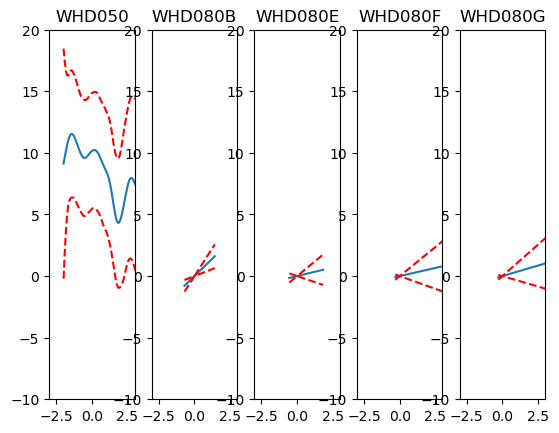

In [19]:
# plotting  假设了同方差
fig, axs = plt.subplots(1,5)
titles = X_gam.columns.values.tolist()[:5]
for i, ax in enumerate(axs):
    #
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_ylim(-10,20)
    ax.set_xlim(-3,3)
    ax.set_title(titles[i])

_ = plt.show()

### Method4: Random forest

In [20]:
rf =  RandomForestRegressor(n_estimators=500, random_state=0, 
                            oob_score=True, max_depth=7,
                            max_features = 7)
rf.fit(X_train, Y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print('MSE:',mean_squared_error(Y_test,y_test_pred))
print('R^2 train:',f'\033[1m{r2_score(Y_train,y_train_pred):.3f}\033[0m')
print('R^2 test: ',f'\033[1m{r2_score(Y_test,y_test_pred):.3f}')

MSE: 240.31665305867912
R^2 train: 0.318
R^2 test:  0.030


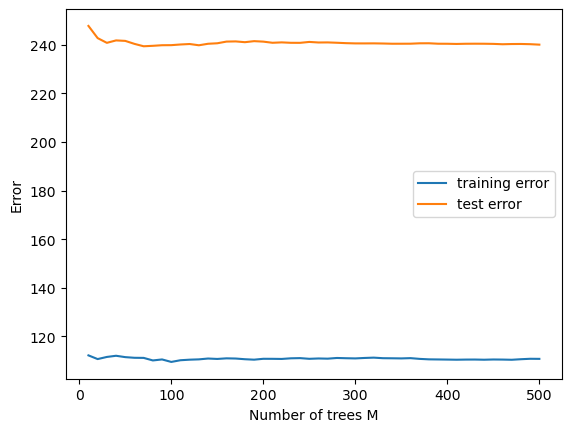

In [21]:
# calculate the error at each iteration
dim_plot = 50
train_error = np.zeros(dim_plot)
test_error = np.zeros(dim_plot)
for i in np.arange(1,dim_plot+1):
    rf =  RandomForestRegressor(n_estimators=i*10, random_state=0, 
                            max_depth=9,
                            max_features = 7)
    rf.fit(X_train, Y_train)
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    train_error[i-1] = mean_squared_error(Y_train, y_train_pred)
    test_error[i-1] =  mean_squared_error(Y_test, y_test_pred) 

# plot    
num_tree = np.arange(1,dim_plot+1,1)
plt.plot(num_tree*10, train_error, label='training error')
plt.plot(num_tree*10, test_error, label='test error')

# plt.scatter(119, 0.100, marker='o', edgecolors='g', s=50)
# plt.annotate('M = 119', xy=(125,0.105), xytext=(200,0.125),
#                 arrowprops=dict(facecolor='yellow', shrink=0.002))

plt.xlabel("Number of trees M")
plt.ylabel("Error")
plt.legend()

_ = plt.show()

In [53]:
forest_importance_data = forest_importances.sort_values(ascending = True).tail(10)
forest_importance_data.index = ['moderate execise', 'ready-to-eat food', 'intemperance',
                               'frozen meals/pizza', 'alcohol frequency', 'cigarette', 'alcohol severity', 
                                'sedentary', 'original weight', 'age']
forest_importance_data

moderate execise      0.023034
ready-to-eat food     0.029574
intemperance          0.032818
frozen meals/pizza    0.035863
alcohol frequency     0.036044
cigarette             0.038083
alcohol severity      0.047831
sedentary             0.076621
original weight       0.105257
age                   0.108208
dtype: float64

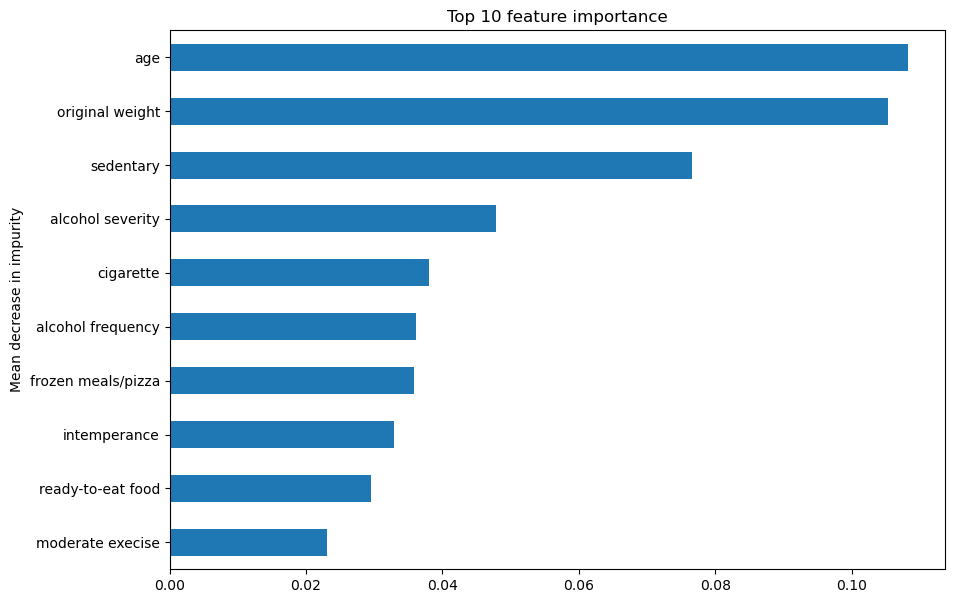

In [56]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index= X_test_df.columns)
forest_importance_data = forest_importances.sort_values(ascending = True).tail(10)
forest_importance_data.index = ['moderate execise', 'ready-to-eat food', 'intemperance',
                               'frozen meals/pizza', 'alcohol frequency', 'cigarette', 'alcohol severity', 
                                'sedentary', 'original weight', 'age']

plt.figure(figsize=(10,7))
forest_importance_data.plot.barh()
plt.ylabel("Mean decrease in impurity")
plt.title("Top 10 feature importance")
plt.savefig('picture_3.jpg')  
_ = plt.show()

In [24]:
# Calculate MSE across folds
scores = -cross_val_score(rf, X_wls, Y_wls, scoring='neg_mean_squared_error', cv=cv)
scores

array([185.41310753, 237.21976114, 202.89717084, 220.75562263,
       222.53039132])

In [25]:
print(f"Mean MSE: {scores.mean():.4f}, plus minus {np.sqrt(scores.var()/len(scores)):.4f}")

Mean MSE: 213.7632, plus minus 7.9944


### Method5: Boosting

In [26]:
boost = HistGradientBoostingRegressor(random_state=0, learning_rate=0.001,
                                      max_iter = 2000, max_depth = 5)
boost.fit(X_train, Y_train)

y_train_pred = boost.predict(X_train)
y_test_pred = boost.predict(X_test)

print('MSE:',mean_squared_error(Y_test,y_test_pred))
print('R^2 train:',f'\033[1m{r2_score(Y_train,y_train_pred):.3f}\033[0m')
print('R^2 test: ',f'\033[1m{r2_score(Y_test,y_test_pred):.3f}')

MSE: 239.85713241983328
R^2 train: 0.209
R^2 test:  0.032


In [27]:
# Calculate MSE across folds
scores_boost = -cross_val_score(boost, X_wls, Y_wls, scoring='neg_mean_squared_error', cv=cv)
scores_boost

array([192.84676643, 241.84329731, 207.19904795, 221.482618  ,
       219.26562787])

In [28]:
print(f"Mean MSE: {scores_boost.mean():.4f}, plus minus {np.sqrt(scores_boost.var()/len(scores)):.4f}")

Mean MSE: 216.5275, plus minus 7.2684


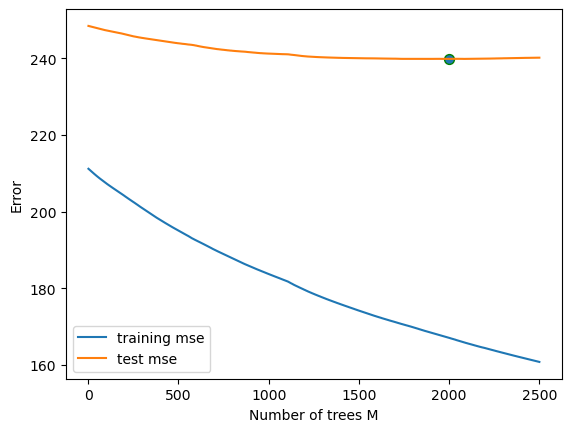

In [29]:
# calculate the error at each iteration
boost = HistGradientBoostingRegressor(random_state=0, learning_rate=0.001,
                                      max_iter = 2500, max_depth = 5)
boost.fit(X_train, Y_train)

dim_plot = 2500
train_error = np.zeros(dim_plot)
test_error = np.zeros(dim_plot)
for i,j in enumerate(boost.staged_predict(X_train)):
    train_error[i] = mean_squared_error(Y_train, j)
for i,j in enumerate(boost.staged_predict(X_test)):
    test_error[i] =  mean_squared_error(Y_test, j)   

# plot    
num_tree = np.arange(1,dim_plot+1,1)
plt.plot(num_tree, train_error, label='training mse')
plt.plot(num_tree, test_error, label='test mse')

plt.scatter(2000, 239.857, marker='o', edgecolors='g', s=50)
# plt.annotate('M = 119', xy=(125,0.105), xytext=(200,0.125),
#                 arrowprops=dict(facecolor='yellow', shrink=0.002))

plt.xlabel("Number of trees M")
plt.ylabel("Error")
plt.legend()
plt.savefig('picture_4.jpg')

_ = plt.show()

## Appendix


#### Picture1. Strategy and Y

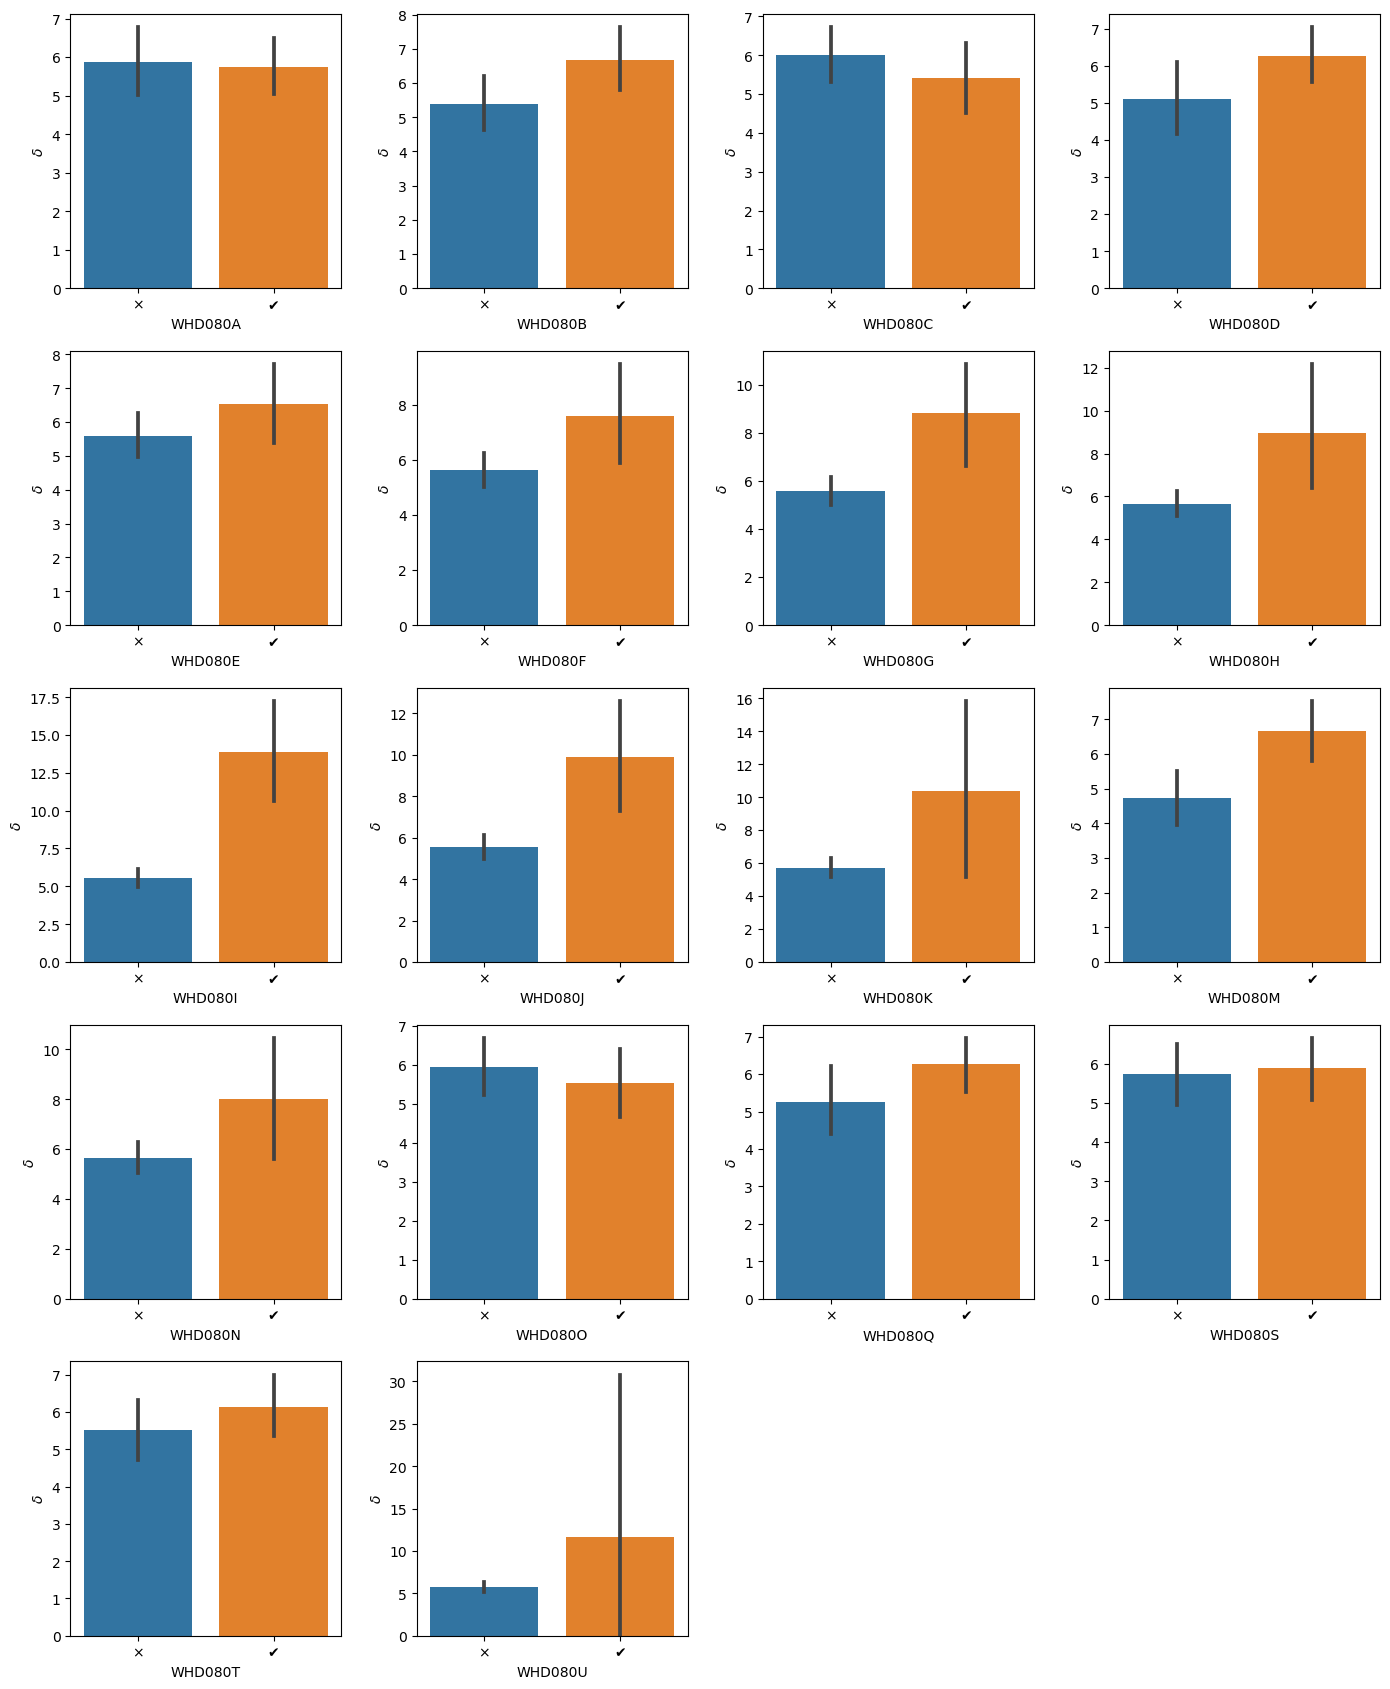

In [30]:
# let's focus on the question of Up vs Down.
# make some side-by-side boxplots
var_wl = ['WHD080A', 'WHD080B', 'WHD080C', 'WHD080D',
         'WHD080E', 'WHD080F', 'WHD080G', 'WHD080H', 
         'WHD080I', 'WHD080J', 'WHD080K','WHD080M',
         'WHD080N', 'WHD080O', 'WHD080Q', 'WHD080S',
         'WHD080T', 'WHD080U']
plt.figure(figsize=(14, 17))

for i,nm in enumerate(var_wl):
    plt.subplot(5,4,i+1)
    data_subplot = df_wls.loc[:,[nm,'weight_change']]
    _ = sns.barplot(x = nm, y = 'weight_change',
           data = data_subplot)
    plt.ylabel(r'$\delta$')
    plt.xticks([0,1],['×','✔'])
plt.savefig('picture_2.jpg')    
plt.tight_layout()
_ = plt.show()

#### Picture2. Distribution of Y (i.e. change_weight)

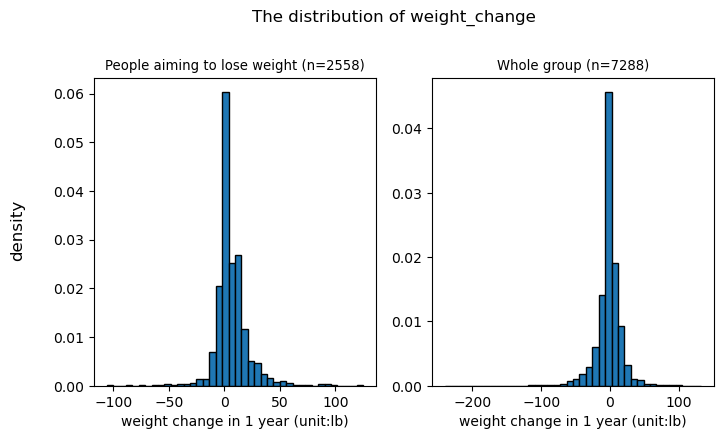

In [31]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(8,4)
# ax1.set_xlim([-0.1, 1])
# ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

ax1.hist(Y,bins = 40, density = True, edgecolor='black')
ax2.hist(df_all['WHD020'].values - df_all['WHD050'].values,
         bins = 40, density = True, edgecolor='black')


ax1.set_xlabel('weight change in 1 year (unit:lb)', y = -0.05)
ax2.set_xlabel('weight change in 1 year (unit:lb)', y = -0.05)
fig.supylabel('density')
ax1.set_title('People aiming to lose weight (n=2558)',fontsize = 9.5)
ax2.set_title('Whole group (n=7288)',fontsize = 9.5)
fig.suptitle('The distribution of weight_change',
             y = 1.05, fontweight = 'medium')
plt.savefig('picture_1.jpg')
_ = plt.show()

-------------------------------------------------